### Example Naive bayes in text processing on Sastrawi and Nltk

In [142]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

import pickle 
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [143]:
products = pd.read_csv('./dataset/products_terbaru.csv')
reviews = pd.read_csv('./dataset/reviews_.csv')

In [144]:
products = products[['id', 'name', 'price', 'rating', 'slug_product', 'image_product']]
reviews = reviews[['product', 'name','comment', 'rating', 'sentiment', 'user']]

In [145]:
reviews['sentiment'].value_counts()

sentiment
negatif    637
positif    635
Name: count, dtype: int64

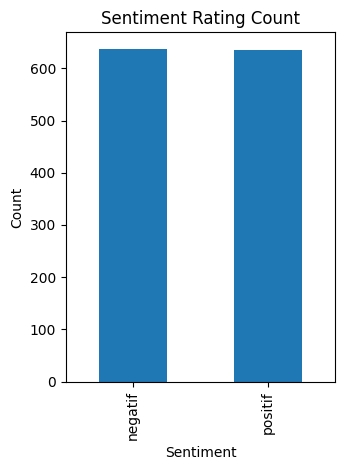

In [146]:
plt.subplot(1, 2, 2)
reviews['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Rating Count')

plt.tight_layout()
plt.show()

### word cloud positif

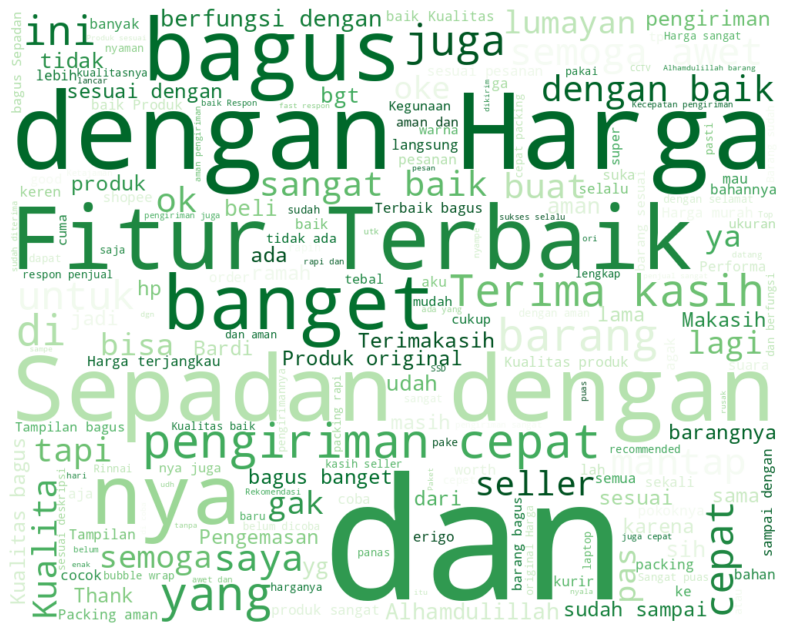

In [147]:
# wordcloud review
data_pos = reviews[reviews['sentiment'] == 'positif']

all_text = ' '.join(word for word in data_pos['comment'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=800, mode='RGBA', background_color='white').generate(all_text)

plt.figure(figsize=(20,10), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()





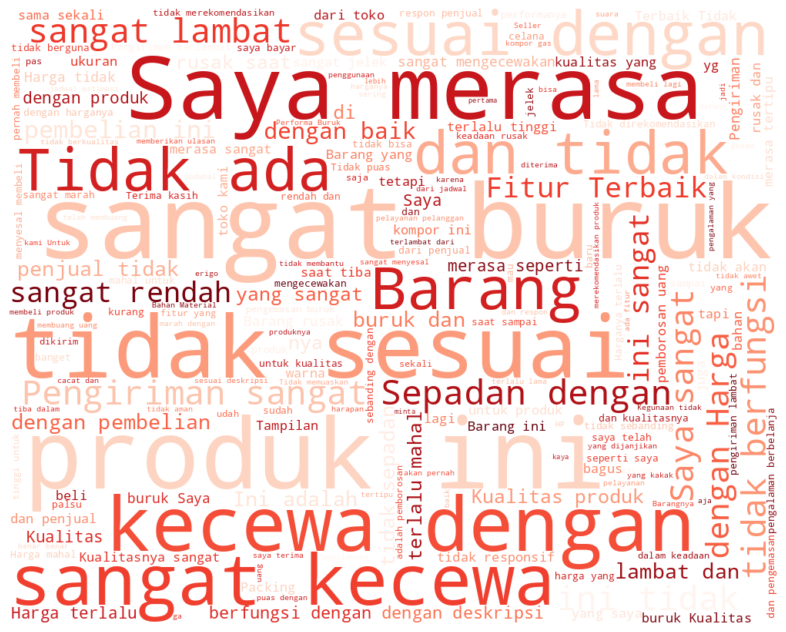

In [148]:
data_neg = reviews[reviews['sentiment'] == 'negatif']

all_text = ' '.join(word for word in data_neg['comment'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=800, mode='RGBA', background_color='white').generate(all_text)

plt.figure(figsize=(20,10), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


In [149]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

def text_preprocessing_indonesia(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()

    # Menghapus tanda baca
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenisasi teks (sesuai dengan bahasa Indonesia)
    tokens = text.split()  # Anda dapat menggunakan tokenisasi yang sesuai dengan bahasa Indonesia

    # Menghapus kata-kata stop (kata-kata umum yang tidak bermakna)
    stop_factory = StopWordRemoverFactory()
    stopword = stop_factory.create_stop_word_remover()
    tokens = [word for word in tokens if word not in stopword.remove(word)]

    # Stemming kata-kata
    stem_factory = StemmerFactory()
    stemmer = stem_factory.create_stemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Contoh penggunaan fungsi preprocessing untuk DataFrame 'reviews'
reviews['comment'] = reviews['comment'].apply(text_preprocessing_indonesia)


In [150]:
negative_reviews = reviews[reviews['sentiment'] == 'negatif'].sample(n=min(620, len(reviews[reviews['sentiment'] == 'negatif'])), replace=True)
positive_reviews = reviews[reviews['sentiment'] == 'positif'].sample(n=min(620, len(reviews[reviews['sentiment'] == 'positif'])), replace=True)
sampled_reviews = pd.concat([negative_reviews, positive_reviews])

In [151]:
encoder = LabelEncoder()
sampled_reviews['sentiment_encoded'] = encoder.fit_transform(sampled_reviews['sentiment'])


In [152]:
X_train, X_test, y_train, y_test = train_test_split(sampled_reviews['comment'], sampled_reviews['sentiment_encoded'], test_size=0.2, random_state=42)

In [153]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [154]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [155]:
y_pred = model.predict(X_test_tfidf)

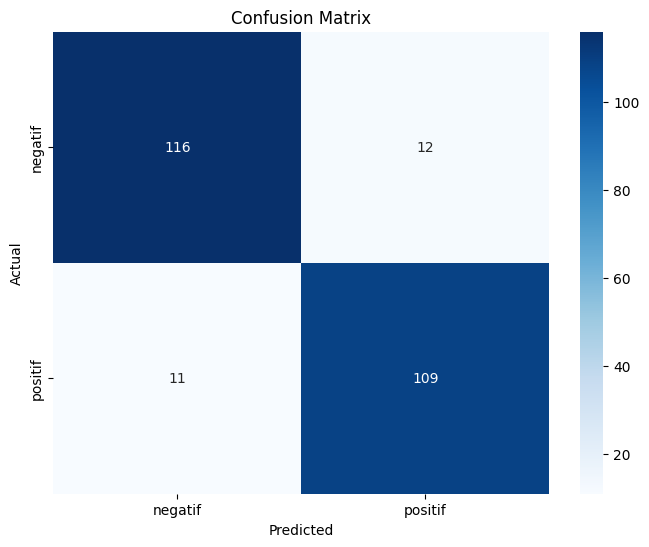

In [156]:
confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [157]:

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=encoder.classes_)

print("Sentiment Analysis Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Sentiment Analysis Accuracy: 0.907258064516129
Classification Report:
               precision    recall  f1-score   support

     negatif       0.91      0.91      0.91       128
     positif       0.90      0.91      0.90       120

    accuracy                           0.91       248
   macro avg       0.91      0.91      0.91       248
weighted avg       0.91      0.91      0.91       248



In [158]:
test_reviews = ["Produk ini sangat buruk! Saya sangat puas dengan kualitasnya.",
                "Barangnya datang baik, dan pelayanannya baik.",
                "Harganya terlalu tinggi untuk kualitas yang ditawarkan."]


preprocessed_reviews = [text_preprocessing_indonesia(review) for review in test_reviews]


test_reviews_tfidf = tfidf_vectorizer.transform(preprocessed_reviews)


predicted_sentiments = model.predict(test_reviews_tfidf)

decoded_sentiments = encoder.inverse_transform(predicted_sentiments)


for i in range(len(test_reviews)):
    print(f"Komentar: {test_reviews[i]}")
    print(f"Prediksi Sentimen: {decoded_sentiments[i]}")
    print()



Komentar: Produk ini sangat buruk! Saya sangat puas dengan kualitasnya.
Prediksi Sentimen: negatif

Komentar: Barangnya datang baik, dan pelayanannya baik.
Prediksi Sentimen: positif

Komentar: Harganya terlalu tinggi untuk kualitas yang ditawarkan.
Prediksi Sentimen: negatif



### Merge the 'reviews' and 'products' dataframes based on 'product'

In [159]:
merged_df = pd.merge(reviews, products, left_on='product', right_on='id')

### Calculate the average rating for each product based on reviews

In [160]:

average_review_ratings = merged_df.groupby('id')['rating_x'].mean().reset_index()

### Merge the average review ratings back into the 'products' dataframe

In [161]:
products['average_review_rating'] = average_review_ratings['rating_x']

### Calculate the final combined rating as the average of product rating and average review rating

In [162]:
products['combined_rating'] = (products['rating'] + products['average_review_rating']) / 2


### Sort products by highest predicted rating and lowest price

In [163]:
recommended_products = products.sort_values(by=['combined_rating', 'price'], ascending=[False, True])


### Delete Average_review_ratings

In [164]:
recommended_products = recommended_products.drop('average_review_rating', axis=1)


### Rename Rating

In [165]:
recommended_products = recommended_products.rename(columns={'combined_rating': 'rating'})


### Print out Recommended Product

In [166]:
recommended_products[['name', 'price', 'image_product','rating']]

,name,price,image_product,rating,rating
32,Xiaomi POCO X5 Pro 5G (6GB/128GB),3819000,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.229687
14,Sandisk Ultra Micro SDXC UHS 128 GB,178000,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.220000
12,SanDisk SSD PLUS Solid 240GB SPEED UP/TO 530MB/S,541500,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.216667
38,BARDI Dual Smart Plug,15000,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.201562
6,Mouse Wireless ROBOT M205 2.4G 1600DPI,89900,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.201562
17,TEAMGROUP SSD 2.5 GX2 128GB Grey,220000,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.201562
8,Robot TWS Wireless Earphone Airbuds T30,134900,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.196875
37,BARDI Smart UNIVERSAL IR REMOTE,135000,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.196875
26,Rinnai Kompor Gas 1 Tungku RI TL 289 / TL289,696000,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.196875
28,Rinnai Kompor Gas 1 Tungku RI 301S / 301S,220900,https://res.cloudinary.com/dv3100rvl/image/upl...,5.0,4.195312


#### Out

In [167]:
output_file = 'recommended_products.pkl'

# Simpan DataFrame ke dalam file pickle
with open(output_file, 'wb') as file:
    pickle.dump(recommended_products, file)

print(f'Recommended products telah disimpan dalam file pickle: {output_file}')

Recommended products telah disimpan dalam file pickle: recommended_products.pkl


In [168]:
with open(output_file, 'rb') as file:
    loaded_recommended_products = pickle.load(file)



loaded_recommended_products

,id,name,price,rating,slug_product,image_product,rating
32,33,Xiaomi POCO X5 Pro 5G (6GB/128GB),3819000,5.0,xiaomi-poco-x5-pro-5g-6gb128gb,https://res.cloudinary.com/dv3100rvl/image/upl...,4.229687
14,15,Sandisk Ultra Micro SDXC UHS 128 GB,178000,5.0,sandisk-ultra-micro-sdxc-uhs-128-gb,https://res.cloudinary.com/dv3100rvl/image/upl...,4.220000
12,13,SanDisk SSD PLUS Solid 240GB SPEED UP/TO 530MB/S,541500,5.0,sandisk-ssd-plus-solid-240gb-speed-upto-530mbs,https://res.cloudinary.com/dv3100rvl/image/upl...,4.216667
38,39,BARDI Dual Smart Plug,15000,5.0,bardi-dual-smart-plug,https://res.cloudinary.com/dv3100rvl/image/upl...,4.201562
6,7,Mouse Wireless ROBOT M205 2.4G 1600DPI,89900,5.0,mouse-wireless-robot-m205-24g-1600dpi,https://res.cloudinary.com/dv3100rvl/image/upl...,4.201562
17,18,TEAMGROUP SSD 2.5 GX2 128GB Grey,220000,5.0,teamgroup-ssd-25-gx2-128gb-grey,https://res.cloudinary.com/dv3100rvl/image/upl...,4.201562
8,9,Robot TWS Wireless Earphone Airbuds T30,134900,5.0,robot-tws-wireless-earphone-airbuds-t30,https://res.cloudinary.com/dv3100rvl/image/upl...,4.196875
37,38,BARDI Smart UNIVERSAL IR REMOTE,135000,5.0,bardi-smart-universal-ir-remote,https://res.cloudinary.com/dv3100rvl/image/upl...,4.196875
26,27,Rinnai Kompor Gas 1 Tungku RI TL 289 / TL289,696000,5.0,rinnai-kompor-gas-1-tungku-ri-tl-289-tl289,https://res.cloudinary.com/dv3100rvl/image/upl...,4.196875
28,29,Rinnai Kompor Gas 1 Tungku RI 301S / 301S,220900,5.0,rinnai-kompor-gas-1-tungku-ri-301s-301s,https://res.cloudinary.com/dv3100rvl/image/upl...,4.195312
